### Data Preparation & Log Returns

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
# Load Brent oil price data
df = pd.read_csv("../data/BrentOilPrices.csv")
# Convert Date to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True, errors='coerce')
df.sort_values("Date", inplace=True)
df.set_index("Date", inplace=True)

# Compute log returns
df['Log_Returns'] = np.log(df['Price'] / df['Price'].shift(1))
df.dropna(inplace=True)  # Remove the first row (NaN)

# Preview
df[['Price', 'Log_Returns']].head()


,Price,Log_Returns
Date,,
1987-05-21,18.45,-0.009709
1987-05-22,18.55,0.005405
1987-05-25,18.60,0.002692
1987-05-26,18.63,0.001612
1987-05-27,18.60,-0.001612


### Plot Raw Prices and Log Returns

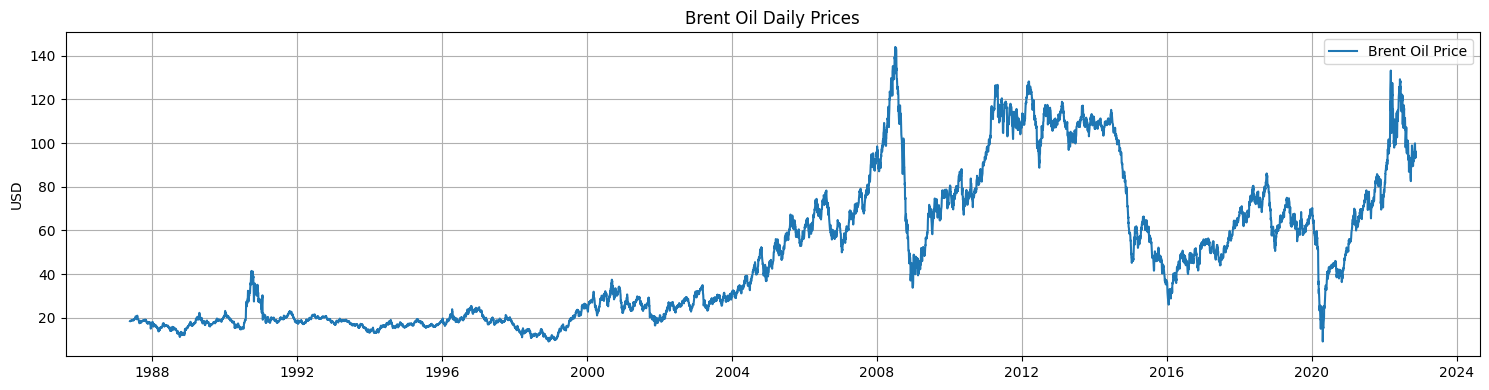

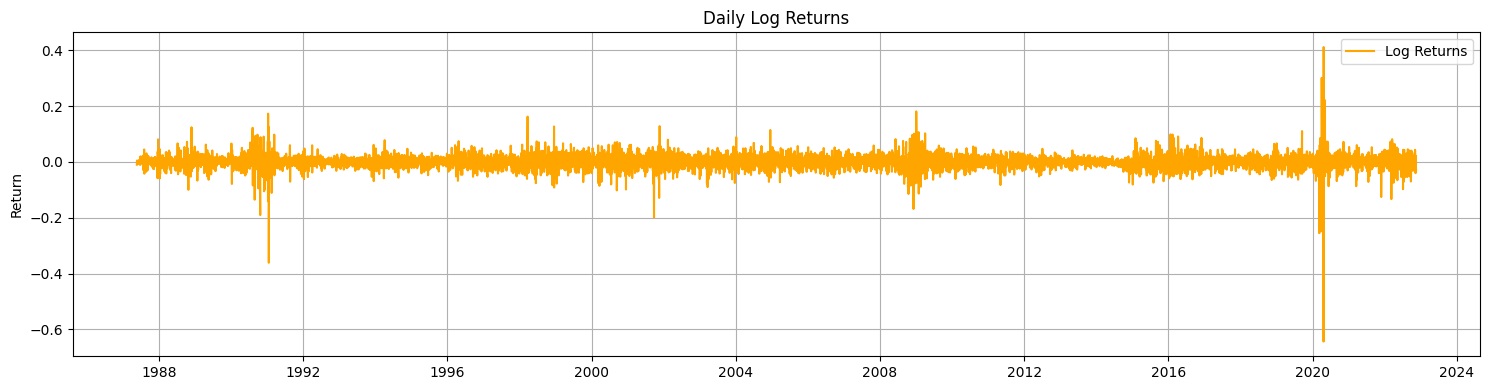

In [6]:
# Plot price
plt.figure(figsize=(15, 4))
plt.plot(df.index, df['Price'], label='Brent Oil Price')
plt.title("Brent Oil Daily Prices")
plt.ylabel("USD")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot log returns
plt.figure(figsize=(15, 4))
plt.plot(df.index, df['Log_Returns'], label='Log Returns', color='orange')
plt.title("Daily Log Returns")
plt.ylabel("Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Bayesian Change Point Model (PyMC3)

In [8]:
import pymc as pm
import arviz as az

# Prepare return series
returns = df['Log_Returns'].values
n = len(returns)

with pm.Model() as model:
    # Prior for change point (tau)
    tau = pm.DiscreteUniform('tau', lower=0, upper=n)

    # Priors for mean before and after
    mu1 = pm.Normal('mu1', mu=0, sigma=1)
    mu2 = pm.Normal('mu2', mu=0, sigma=1)

    # Common standard deviation
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Mean selection based on tau
    mu = pm.math.switch(tau > np.arange(n), mu1, mu2)

    # Likelihood
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=returns)

    # Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


d:\brent-oil-event-impact-analysis\venv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ValueError: Not enough samples to build a trace.

### Interpretation: Trace Plot & Summary

In [ ]:
# Trace and summary
az.plot_trace(trace, var_names=['tau', 'mu1', 'mu2'])
plt.tight_layout()
plt.show()

summary = az.summary(trace, var_names=['tau', 'mu1', 'mu2'])
print(summary)


### Identify Change Point Date

In [1]:
# Extract most probable change point
tau_mean = int(trace.posterior['tau'].mean().values)
change_point_date = df.index[tau_mean]
print(f"📌 Change point detected around: {change_point_date.date()}")


NameError: name 'trace' is not defined

### Quantify the Impact

In [ ]:
mu1_val = trace.posterior['mu1'].mean().values
mu2_val = trace.posterior['mu2'].mean().values
shift = (mu2_val - mu1_val) * 100

print(f"""
Mean Log Return Before: {mu1_val:.5f}
Mean Log Return After : {mu2_val:.5f}
Change in mean daily return ≈ {shift:.3f}%
""")
